# このノートでやった（できる）こと
### Logistic regressionを用いて、目的変数の確率を算出し、算出した値を元に様々な掛け方をした場合の回収率を計算

#### 計算に用いた特徴量
- 各レーサーのクラス
- 各レーサーの各枠における平均スタートタイム
- 各レーサーの連帯率
- 展示タイム
- 各モーターの2連率
- 各モーターの3連率

#### 目的変数
- 1枠: 1着になる (1) or ならない (0)
- 2-6枠: 3着以内にはいる (1) or 入らない (0)


### 結果
#### Logistic Regression結果
- Logistic_regression_1よりは全体的にいい結果になるが、まだ実用化にたるものとは言えない。ギャンブル性がある。
- regressionに使う結果を、半年分入れるよりも、1ヶ月分など短期にする方が予測精度が上がる可能性がある
#### bet結果


In [72]:
# 必要なモジュールのインポート

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import termcolor

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [73]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.make_merged_df()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
# print(the_merged_df["exhibitionTime_1"])

In [74]:
# logistic regressionを利用した学習

def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # ラベルの数を変数名にしておく。labelと特徴量を分けるときに使う
    num_labels = len(column_list_label)

    # 解析用dfを作成
    fv_label_odds_df = the_merged_df[fv_list + column_list_label + odds_list]
    
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = fv_label_odds_df[fv_list + column_list_label ]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_label_df.replace(key, value, inplace = True)

    # なぜかdtypeがstrになっちゃうのでintに戻す
    fv_labe_df = fv_label_df.astype(float)

    # ラベルをbooleanに変換
    fv_label_df = analyzer_conf.make_label_boolean_ver1(
        fv_label_df, column_list_label)
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))
    
    """
    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
    """        
    return fv_label_df, fv_label_odds_df


def separate_train_test_dataset(for_analysis_df, train_data_ratio):
       
    # 解析用df（特徴量+label）を、学習用データとテストデータのarrayに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values
    
    return train_data, test_data, train_size

    
def learn_logistic_regression(train_data, column_list_label):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
    # ラベルとしてもちいる部分の数。labelと特徴量を分ける際に使用、
    num_labels = len(column_list_label)
    
    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]

    # ロジスティック回帰を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # ロジスティック回帰
        clf = LogisticRegression()
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list, num_labels


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []
for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各枠の平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    # 展示タイム
    fv_list.append("exhibitionTime_{0}".format(i))
    
    # 各モーターの2連率, 3連率
    fv_list.append("motor_place2Ratio_{0}".format(i))
    fv_list.append("motor_place3Ratio_{0}".format(i))

# 解析に使うラベルカラム: 1枠が1着になるか, 2枠以降は3着以降に入るかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.7

# --------------------------------

# main

fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
train_data, test_data, train_size = separate_train_test_dataset(fv_label_df, train_data_ratio)
clf_list, num_labels = learn_logistic_regression(train_data, column_list_label)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


解析用dfの行数は.24159


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

1号艇についてtrainデータを使った正解率は0.6492223996215482,
           testデータを使った正解率は0.6397626931567328
切片は[0.10381278]
class_1 -0.507593582174119 

aveST_frame1 -0.030564135212123276 

placeRate_frame1 0.00147101404928881 

exhibitionTime_1 -2.0359753035041215 

motor_place2Ratio_1 0.007213263712740431 

motor_place3Ratio_1 0.0009852062682495365 

class_2 0.0656501493693665 

aveST_frame2 -0.01088152609206085 

placeRate_frame2 -0.00038354525407797725 

exhibitionTime_2 0.6516423966599599 

motor_place2Ratio_2 0.0010427605241888885 

motor_place3Ratio_2 -0.0035159832674228086 

class_3 0.014728192091405048 

aveST_frame3 0.008731910579937212 

placeRate_frame3 -0.0002452009450269541 

exhibitionTime_3 0.5471339399543289 

motor_place2Ratio_3 -0.008487520292150462 

motor_place3Ratio_3 0.0052507904526724256 

class_4 0.06726000453574736 

aveST_frame4 0.010687658450765115 

placeRate_frame4 -0.0002569646567960865 

exhibitionTime_4 0.7240416771569954 

motor_place2Ratio_4 0.0005871299267272241 

motor

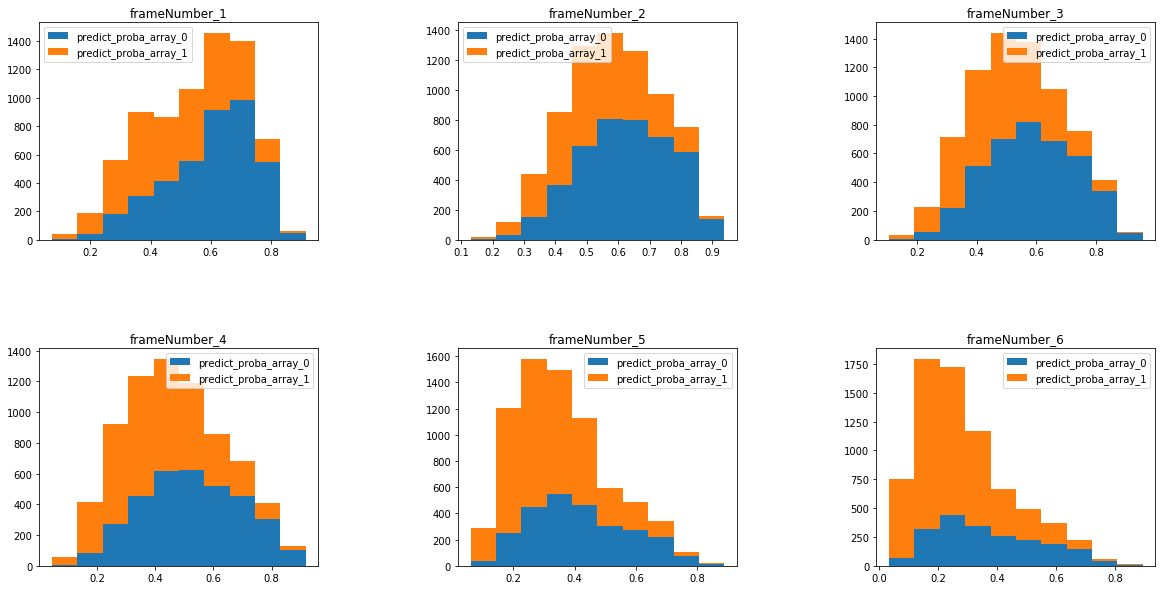

In [75]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

# 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
train_x = train_data[:, :-num_labels]
test_x = test_data[:, :-num_labels]

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))

    # 最適化された結果の切片と重みを取得
    intercept =clf.intercept_
    coef = clf.coef_
    print("切片は{0}".format(intercept))
    for j in range (coef.shape[1]):
        print(fv_list[j], coef[0, j], "\n")

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()


# 考察
- 正解率はいずれのラベルに対しても6割から7割程度にとどまるが、test dataとtraining dataで同程度の正解率をだす。
確率ごとにプロットをしてみると、
- predict_probaが小さい時は実際に0ラベル、predict_probaが大きい時は実際に1ラベルであることがかなり多くなっている。
- 正解率を下げているのは実際に判断が難しいところ（0.3 < predict_proba < 0.7くらいの場所） であり、predict_probaが高いところ、低いところを抽出して用いることで十分に予測器として使用可能
- 1着以外が1位になる，荒れるレースの予測や、1着を1枠に固定し、2, 3を高いprobabilityを示すものでbox買するといったオプションが考えられる。

そこで、以下のセルにおいては掛け方を色々してみた時の回収率計算を行う。

In [76]:
# 計算用dfを作成
# 6列目までが上の解析によって求めた確率(1号艇が1位になる率, 2-6号艇が3位以内に入る確率)
# 7列目以降にオッズ関係の値を格納

for_calc_refund_rate_df = pd.DataFrame(np.vstack(predict_proba_array_list).T, columns=["PredProb_{0}".format(i) for i in range(1, 7)])
for odds_column_name in odds_list:
    # TODO intで入れられるものはintで。無理なものはとりあえずobjectのままで格納
    for_calc_refund_rate_df[odds_column_name] = fv_label_odds_df[odds_column_name][train_size:].values

print(for_calc_refund_rate_df)

      PredProb_1  PredProb_2  PredProb_3  PredProb_4  PredProb_5  PredProb_6  \
0       0.763646    0.767800    0.290088    0.223692    0.644761    0.168486   
1       0.742054    0.606553    0.366467    0.549890    0.175261    0.355048   
2       0.659637    0.575109    0.487215    0.367074    0.335133    0.418068   
3       0.371400    0.774840    0.883260    0.141915    0.314373    0.131923   
4       0.744013    0.510879    0.802524    0.099645    0.241919    0.576226   
5       0.718815    0.479370    0.370273    0.270155    0.483303    0.488121   
6       0.461885    0.904285    0.207889    0.422745    0.260413    0.344348   
7       0.634050    0.860587    0.421359    0.145079    0.206055    0.534425   
8       0.692299    0.674902    0.410712    0.836376    0.282973    0.047353   
9       0.670190    0.751832    0.375416    0.264584    0.239737    0.608435   
10      0.586284    0.809418    0.752093    0.098072    0.121725    0.700350   
11      0.759755    0.855306    0.162030

In [77]:
# 確率x_1以上のときのみ、1に単勝賭けした時の回収率
x_1_list = [0.6, 0.7, 0.8]
for x_1 in x_1_list:
    bet = sum(for_calc_refund_rate_df["PredProb_1"] > x_1)

    return_boolean = (for_calc_refund_rate_df["PredProb_1"] > x_1) & (for_calc_refund_rate_df["win"] == "1")
    return_ = sum(for_calc_refund_rate_df["winOdds"][return_boolean])

    print("確率{0}以上で1に単勝betした場合、的中率は{1}, 回収率は{2}".format(x_1, sum(return_boolean) / bet, return_ / (bet * 100)))

確率0.6以上で1に単勝betした場合、的中率は0.7020232985898222, 回収率は0.9158798283261803
確率0.7以上で1に単勝betした場合、的中率は0.7506666666666667, 回収率は0.915
確率0.8以上で1に単勝betした場合、的中率は0.8333333333333334, 回収率は0.9519047619047619


In [78]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率がx_2超えがあった場合に、1-XY..の形で2連単bet

x_1_list = [0.7, 0.75, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "1-{0}".format(j)
                        bet = bet + 100
                        if row["exacta"] == bet_num:
                            income = income + row["exactaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で2連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.7以上かつ、p2-6が0.5以上で2連単betすると収益は-47420, 回収率は0.8211915535444947
p1が0.7以上かつ、p2-6が0.6以上で2連単betすると収益は-30120, 回収率は0.7948228882833788
p1が0.7以上かつ、p2-6が0.7以上で2連単betすると収益は-10810, 回収率は0.8116724738675958
p1が0.7以上かつ、p2-6が0.8以上で2連単betすると収益は-5060, 回収率は0.6107692307692307
p1が0.75以上かつ、p2-6が0.5以上で2連単betすると収益は-21620, 回収率は0.8217642209398186
p1が0.75以上かつ、p2-6が0.6以上で2連単betすると収益は-13770, 回収率は0.7861801242236025
p1が0.75以上かつ、p2-6が0.7以上で2連単betすると収益は-3630, 回収率は0.835
p1が0.75以上かつ、p2-6が0.8以上で2連単betすると収益は-1480, 回収率は0.6711111111111111
p1が0.8以上かつ、p2-6が0.5以上で2連単betすると収益は-4560, 回収率は0.8583850931677018
p1が0.8以上かつ、p2-6が0.6以上で2連単betすると収益は-3240, 回収率は0.785430463576159
p1が0.8以上かつ、p2-6が0.7以上で2連単betすると収益は-2270, 回収率は0.4955555555555556
p1が0.8以上かつ、p2-6が0.8以上で2連単betすると収益は-470, 回収率は0.21666666666666667


In [79]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9と1-9-Xの形で3連単bet
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 200
                                bet_num_1 = "1-{0}-{1}".format(j, k)
                                bet_num_2 = "1-{0}-{1}".format(k, j)
                                # print(bet_num_1, bet_num_2, row["trifecta"], row["trifectaOdds"])
                                if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-610340, 回収率は0.7652538461538462
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-314200, 回収率は0.7137390670553936
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-89460, 回収率は0.6858848314606741
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-265690, 回収率は0.7737653269754768
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-138230, 回収率は0.698976480836237
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-28040, 回収率は0.7303846153846154
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-47910, 回収率は0.6033940397350993
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は-15460, 回収率は0.5705555555555556
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は-480, 回収率は0.9


In [80]:
# 上と同じノリで2着固定。すなわち、
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9の形で3連単bet
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-1296230, 回収率は0.74722503900156
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-825050, 回収率は0.7622608344859382
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-510730, 回収率は0.7353730569948187
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-230620, 回収率は0.7319618781961879
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-81090, 回収率は0.6676639344262295
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-836610, 回収率は0.7636160714285715
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-502010, 回収率は0.7882886302294198
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-305350, 回収率は0.7651153846153846
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-126240, 回収率は0.7699708454810495
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-49730, 回収率は0.6507724719101123
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-390390, 回収率は0.7503261703760553
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-260720, 回収率は0.7542232277526395
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-161800, 回収率は0.7244550408719346
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-68430, 回収率は0.7019599303135888
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-26940, 回収率は0.4819230769230769
p1が0.8以上かつ、p2-6

In [81]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以下が2艇以上あった場合に、1頭で、2割以下艇を外した残りを2, 3着boxにして買う
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.4, 0.3, 0.2]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                outers = (row[["PredProb_{0}".format(n) for n in range(2, 7)]] < x_2)
                num_outers = sum(outers)
                if (num_outers > 1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-229140, 回収率は0.825430443394789
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-92070, 回収率は0.8841012084592145
p1が0.6以上かつ、p2-6が0.2以上で3連単betすると収益は-21250, 回収率は0.8266721044045677
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-87480, 回収率は0.8525783619817998
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-35980, 回収率は0.9155002348520432
p1が0.7以上かつ、p2-6が0.2以上で3連単betすると収益は-13660, 回収率は0.787227414330218
p1が0.8以上かつ、p2-6が0.4以上で3連単betすると収益は-8850, 回収率は0.8868286445012787
p1が0.8以上かつ、p2-6が0.3以上で3連単betすると収益は2170, 回収率は1.0344444444444445
p1が0.8以上かつ、p2-6が0.2以上で3連単betすると収益は-610, 回収率は0.8870370370370371


In [82]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
x_1_list = [0.5, 0.6, 0.7, 0.75, 0.8]
x_2_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))
        except ZeroDivisionError:
            print("投票候補なし")

p1が0.5以上かつ、p2-6が0.3以上で3連単betすると収益は-1166990, 回収率は0.7519997449846991
p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-459800, 回収率は0.812341849644927
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-144630, 回収率は0.848268988669744
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-46700, 回収率は0.7985332182916307
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は1880, 回収率は1.062251655629139
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-450, 回収率は0.6785714285714286
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-738460, 回収率は0.7702078665670898
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-302960, 回収率は0.8162319543855392
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-95640, 回収率は0.8475127551020408
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-28080, 回収率は0.8066115702479338
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-2330, 回収率は0.8579268292682927
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は150, 回収率は1.1875
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-254270, 回収率は0.8126786503609842
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-115190, 回収率は0.8320355788859726
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-40680, 回収率は0.8486607142857143
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-10660

In [83]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
# ただし、2-6号艇のうち二つ以上の艇がx_２を超えていた場合、それらに対しては2倍のbet額になるアルゴリズムになっている
x_1_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_3_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.4以上かつ、p2が0.4以上かつp3が0で3連単betすると収益は-3218780, 回収率は0.746648510799068
p1が0.4以上かつ、p2が0.4以上かつp3が0.1で3連単betすると収益は-3066410, 回収率は0.7539273275875905
p1が0.4以上かつ、p2が0.4以上かつp3が0.2で3連単betすると収益は-2398550, 回収率は0.7805695831961064
p1が0.4以上かつ、p2が0.4以上かつp3が0.3で3連単betすると収益は-1864790, 回収率は0.7840378468522722
p1が0.4以上かつ、p2が0.4以上かつp3が0.4で3連単betすると収益は-1149720, 回収率は0.8142377043882892
p1が0.4以上かつ、p2が0.5以上かつp3が0で3連単betすると収益は-2063360, 回収率は0.7634195560447624
p1が0.4以上かつ、p2が0.5以上かつp3が0.1で3連単betすると収益は-1960790, 回収率は0.7700762195121951
p1が0.4以上かつ、p2が0.5以上かつp3が0.2で3連単betすると収益は-1540740, 回収率は0.7911540651177922
p1が0.4以上かつ、p2が0.5以上かつp3が0.3で3連単betすると収益は-1140110, 回収率は0.800652189117359
p1が0.4以上かつ、p2が0.5以上かつp3が0.4で3連単betすると収益は-693310, 回収率は0.8265944675103797
p1が0.4以上かつ、p2が0.5以上かつp3が0.5で3連単betすると収益は-338840, 回収率は0.8646805111821086
p1が0.4以上かつ、p2が0.6以上かつp3が0で3連単betすると収益は-1353190, 回収率は0.7300961385032712
p1が0.4以上かつ、p2が0.6以上かつp3が0.1で3連単betすると収益は-1294470, 回収率は0.7346309963099631
p1が0.4以上かつ、p2が0.6以上かつp3が0.2で3連単betすると収益は-1028870, 回収率は0.75045

p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は-330, 回収率は0.9514705882352941
p1が0.6以上かつ、p2が0.8以上かつp3が0.8で3連単betすると収益は300, 回収率は1.1875
p1が0.7以上かつ、p2が0.4以上かつp3が0で3連単betすると収益は-739070, 回収率は0.7636639805576874
p1が0.7以上かつ、p2が0.4以上かつp3が0.1で3連単betすると収益は-726230, 回収率は0.7609827540810953
p1が0.7以上かつ、p2が0.4以上かつp3が0.2で3連単betすると収益は-520040, 回収率は0.7995374296507594
p1が0.7以上かつ、p2が0.4以上かつp3が0.3で3連単betすると収益は-353550, 回収率は0.8193592887798896
p1が0.7以上かつ、p2が0.4以上かつp3が0.4で3連単betすると収益は-230380, 回収率は0.8320355788859726
p1が0.7以上かつ、p2が0.5以上かつp3が0で3連単betすると収益は-481630, 回収率は0.7729873680241327
p1が0.7以上かつ、p2が0.5以上かつp3が0.1で3連単betすると収益は-485190, 回収率は0.7632295529962912
p1が0.7以上かつ、p2が0.5以上かつp3が0.2で3連単betすると収益は-372140, 回収率は0.7841665700034799
p1が0.7以上かつ、p2が0.5以上かつp3が0.3で3連単betすると収益は-230230, 回収率は0.8200765864332604
p1が0.7以上かつ、p2が0.5以上かつp3が0.4で3連単betすると収益は-149090, 回収率は0.8290644347626691
p1が0.7以上かつ、p2が0.5以上かつp3が0.5で3連単betすると収益は-81360, 回収率は0.8486607142857143
p1が0.7以上かつ、p2が0.6以上かつp3が0で3連単betすると収益は-265690, 回収率は0.7737653269754768
p1が0.7以上かつ、p2が0.6以

### 2019年1月の一月に絞ってまわした場合、
下記のような特徴があり、相当うまく行っていることがわかる。正直このまま自動betアルゴリズムにできそう。
- かなりいろんな値で回収率がちゃんとプラスになる
- p1, p2の特定の値でマイナスになったりはしない
- p値を厳しく取るほど回収率は上がる傾向がある。

かと思ったけどそうでもないかな。。。

### 2019年1月から6月まで一緒にしてまわした場合
ほとんど全てのところで回収率マイナスになってしまうぞ。。。。。
p1が0.8超えかつp2, p3を0.6程度にするとプラスになる

In [84]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合
# 1頭で、x_2以上艇を2着候補に, x_３以上の艇を3着候補にしてbet
x_1_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_3_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:

            income = 0
            bet = 0

            for index, row in for_calc_refund_rate_df.iterrows():
                if (row["PredProb_1"] > x_1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
                                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
            try:
                text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                if (income/bet) < 1:
                    text = termcolor.colored(text, 'red')
                print(text)
            except ZeroDivisionError:
                print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.4以上かつ、p2が0.4以上かつp3が0で3連単betすると収益は-1508350, 回収率は0.7625543101819785
p1が0.4以上かつ、p2が0.4以上かつp3が0.1で3連単betすると収益は-1418510, 回収率は0.772335371627586
p1が0.4以上かつ、p2が0.4以上かつp3が0.2で3連単betすると収益は-1119800, 回収率は0.7951110623193179
p1が0.4以上かつ、p2が0.4以上かつp3が0.3で3連単betすると収益は-853780, 回収率は0.8022467225645065
p1が0.4以上かつ、p2が0.4以上かつp3が0.4で3連単betすると収益は-574860, 回収率は0.8142377043882892
p1が0.4以上かつ、p2が0.4以上かつp3が0.5で3連単betすると収益は-335080, 回収率は0.832384573057876
p1が0.4以上かつ、p2が0.4以上かつp3が0.6で3連単betすると収益は-218880, 回収率は0.7955538950121427
p1が0.4以上かつ、p2が0.4以上かつp3が0.7で3連単betすると収益は-96870, 回収率は0.7852582575925515
p1が0.4以上かつ、p2が0.4以上かつp3が0.8で3連単betすると収益は-15670, 回収率は0.8615724381625441
p1が0.4以上かつ、p2が0.5以上かつp3が0で3連単betすると収益は-987320, 回収率は0.7735920014676206
p1が0.4以上かつ、p2が0.5以上かつp3が0.1で3連単betすると収益は-922380, 回収率は0.7836819887429644
p1が0.4以上かつ、p2が0.5以上かつp3が0.2で3連単betすると収益は-717780, 回収率は0.8054111204489387
p1が0.4以上かつ、p2が0.5以上かつp3が0.3で3連単betすると収益は-514600, 回収率は0.8200447615051056
p1が0.4以上かつ、p2が0.5以上かつp3が0.4で3連単betすると収益は-358230, 回収率は0.82080436196288

p1が0.6以上かつ、p2が0.5以上かつp3が0.5で3連単betすると収益は-95640, 回収率は0.8475127551020408
p1が0.6以上かつ、p2が0.5以上かつp3が0.6で3連単betすると収益は-61730, 回収率は0.7986627527723418
p1が0.6以上かつ、p2が0.5以上かつp3が0.7で3連単betすると収益は-18540, 回収率は0.8320652173913043
p1が0.6以上かつ、p2が0.5以上かつp3が0.8で3連単betすると収益は3100, 回収率は1.1377777777777778
p1が0.6以上かつ、p2が0.6以上かつp3が0で3連単betすると収益は-305350, 回収率は0.7651153846153846
p1が0.6以上かつ、p2が0.6以上かつp3が0.1で3連単betすると収益は-279960, 回収率は0.7772615164293102
p1が0.6以上かつ、p2が0.6以上かつp3が0.2で3連単betすると収益は-250310, 回収率は0.7601705470920763
p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-157660, 回収率は0.7978717948717948
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-105580, 回収率は0.7974678687895645
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-54230, 回収率は0.8231245923026745
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-28080, 回収率は0.8066115702479338
p1が0.6以上かつ、p2が0.6以上かつp3が0.7で3連単betすると収益は-5030, 回収率は0.9007889546351084
p1が0.6以上かつ、p2が0.6以上かつp3が0.8で3連単betすると収益は3210, 回収率は1.3178217821782179
p1が0.6以上かつ、p2が0.7以上かつp3が0で3連単betすると収益は-126240, 回収率は0.7699708454810495
p1が0.6以上か

p1が0.8以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-610, 回収率は0.8849056603773585
p1が0.8以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-890, 回収率は0.6291666666666667
p1が0.8以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は50, 回収率は1.0833333333333333
p1が0.8以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-200, 回収率は0.0
p1が0.8以上かつ、p2が0.7以上かつp3が0.8で3連単betすると収益は-100, 回収率は0.0
p1が0.8以上かつ、p2が0.8以上かつp3が0で3連単betすると収益は-2030, 回収率は0.15416666666666667
p1が0.8以上かつ、p2が0.8以上かつp3が0.1で3連単betすると収益は-1930, 回収率は0.1608695652173913
p1が0.8以上かつ、p2が0.8以上かつp3が0.2で3連単betすると収益は-1430, 回収率は0.20555555555555555
p1が0.8以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-630, 回収率は0.37
p1が0.8以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-400, 回収率は0.0
p1が0.8以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は-200, 回収率は0.0
p1が0.8以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は-200, 回収率は0.0
p1が0.8以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は-100, 回収率は0.0
p1=0.8, p2=0.8, p3=0.8の時、投票候補なし


### 2019年1月のデータに絞ってまわした場合
一つ上のセルの結果と同様、かなり安定して回収することを見込めそう。
ただ、こっちの方が実はばらけが出そう。例えばp1 = 0.7, p2 = 0.8の時。p3が0.1と0.6で回収率プラスに出るけど、これはでかいのを一発当てただけっぽい予感がする。

### 2019年1月から6月のデータを用いた場合

In [25]:
# 1号艇以外の艇で3位以内率x_2以上が2艇あった場合に、XY(Z)のワイド
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_2 in x_2_list:

    income = 0
    bet = 0

    for index, row in for_calc_refund_rate_df.iterrows():
        for j in range(2, 7):
            if row["PredProb_{0}".format(j)] > x_2:
                for k in range(j, 7):
                    if k is not j and row["PredProb_{0}".format(k)] > x_2:
                        bet = bet + 100
                        bet_num = "{0}-{1}".format(j, k)
                        if row["wide_1"] == bet_num:
                            income = income + row["wideOdds_1"]
                        elif row["wide_2"] == bet_num:
                            income = income + row["wideOdds_2"]
                        elif row["wide_3"] == bet_num:
                            income = income + row["wideOdds_3"] 
    try:
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))
    except ZeroDivisionError:
        print("投票候補なし")

p1が0.8以上かつ、p2-6が0.5以上で3連単betすると収益は-19690, 回収率は0.8082765335929893
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-6330, 回収率は0.7824742268041237
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は670, 回収率は1.1116666666666666
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は-20, 回収率は0.9333333333333333


In [26]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1-XYで3連複
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(j, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trio"] == bet_num:
                                    income = income + row["trioOdds"]
                                # print(bet_num, row["trio"], row["trioOdds"], bet, income)
        try:
            print("p1が{0}以上かつ、p2-6が{1}以上で3連複betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))
        except ZeroDivisionError:
            print("投票候補なし")

p1が0.5以上かつ、p2-6が0.5以上で3連複betすると収益は-10550, 回収率は0.790258449304175
p1が0.5以上かつ、p2-6が0.6以上で3連複betすると収益は-2750, 回収率は0.7405660377358491
p1が0.5以上かつ、p2-6が0.7以上で3連複betすると収益は-130, 回収率は0.91875
投票候補なし
p1が0.6以上かつ、p2-6が0.5以上で3連複betすると収益は-5130, 回収率は0.846865671641791
p1が0.6以上かつ、p2-6が0.6以上で3連複betすると収益は-710, 回収率は0.9013888888888889
p1が0.6以上かつ、p2-6が0.7以上で3連複betすると収益は200, 回収率は1.1818181818181819
投票候補なし
p1が0.7以上かつ、p2-6が0.5以上で3連複betすると収益は-1980, 回収率は0.8777777777777778
p1が0.7以上かつ、p2-6が0.6以上で3連複betすると収益は-230, 回収率は0.9342857142857143
p1が0.7以上かつ、p2-6が0.7以上で3連複betすると収益は400, 回収率は1.5714285714285714
投票候補なし
p1が0.8以上かつ、p2-6が0.5以上で3連複betすると収益は-1460, 回収率は0.496551724137931
p1が0.8以上かつ、p2-6が0.6以上で3連複betすると収益は-100, 回収率は0.8571428571428571
p1が0.8以上かつ、p2-6が0.7以上で3連複betすると収益は-100, 回収率は0.0
投票候補なし


In [27]:
# 1の確率がx_1以下のとき、2-6号艇の値がx_2以上のものに対して単勝bet
x_1_list = [0.2, 0.3, 0.4, 0.5]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] < x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "{0}".format(j)
                        bet = bet + 100
                        if row["win"] == bet_num:
                            income = income + row["winOdds"]
        print("p1が{0}以下のとき、p2-6が{1}以上なら単勝betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.2以下のとき、p2-6が0.5以上なら単勝betすると収益は-3800, 回収率は0.638095238095238
p1が0.2以下のとき、p2-6が0.6以上なら単勝betすると収益は-3430, 回収率は0.5765432098765432
p1が0.2以下のとき、p2-6が0.7以上なら単勝betすると収益は-1160, 回収率は0.7531914893617021
p1が0.2以下のとき、p2-6が0.8以上なら単勝betすると収益は40, 回収率は1.0235294117647058
p1が0.3以下のとき、p2-6が0.5以上なら単勝betすると収益は-7160, 回収率は0.7396363636363636
p1が0.3以下のとき、p2-6が0.6以上なら単勝betすると収益は-5210, 回収率は0.7328205128205129
p1が0.3以下のとき、p2-6が0.7以上なら単勝betすると収益は-1450, 回収率は0.8644859813084113
p1が0.3以下のとき、p2-6が0.8以上なら単勝betすると収益は-360, 回収率は0.9181818181818182
p1が0.4以下のとき、p2-6が0.5以上なら単勝betすると収益は-13370, 回収率は0.7271428571428571
p1が0.4以下のとき、p2-6が0.6以上なら単勝betすると収益は-9890, 回収率は0.708259587020649
p1が0.4以下のとき、p2-6が0.7以上なら単勝betすると収益は-3830, 回収率は0.7907103825136612
p1が0.4以下のとき、p2-6が0.8以上なら単勝betすると収益は-860, 回収率は0.8925
p1が0.5以下のとき、p2-6が0.5以上なら単勝betすると収益は-21010, 回収率は0.7133697135061392
p1が0.5以下のとき、p2-6が0.6以上なら単勝betすると収益は-15710, 回収率は0.6780737704918033
p1が0.5以下のとき、p2-6が0.7以上なら単勝betすると収益は-5910, 回収率は0.7735632183908046
p1が0.5以下のとき、p2-6が0.8以上なら単勝betすると収益は-1150,